In [3]:
# Install necessary Python packages
# Uncomment as necessary
# !pip install optuna darts chardet seaborn tqdm tensorboard

# Jupyter Notebook environment setup for PyTorch and autoreload extension
get_ipython().run_line_magic('set_env', 'PYTORCH_ENABLE_MPS_FALLBACK=1')
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

# Init Tensorboard
# Uncomment if desired
# %load_ext tensorboard
# %tensorboard --logdir darts_logs --port 6007

# Importing required libraries
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from tabulate import tabulate
import torch
import warnings
import logging

# Suppress warnings and disable logging
warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)




env: PYTORCH_ENABLE_MPS_FALLBACK=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

# Define constants and hyperparameters
EPOCHS = 100
INLEN = 35
HIDDEN = 6
LSTMLAYERS = 3
ATTH = 2
BATCH = 48
LEARN = 0.0010223
DROPOUT = 0.1
VALWAIT = 1
N_FC = 1
RAND = 42
N_SAMPLES = 100
N_JOBS = 12
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
SPLIT = 0.90
FIGSIZE = (9, 6)
qL1, qL2 = 0.01, 0.10
qU1, qU2 = 1-qL1, 1-qL2
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

# Repeatability
torch.manual_seed(RAND)

#formatting
pd.options.display.float_format = '{:,.2f}'.format




In [5]:
################################################################################################################
#
# Defining Helper Functions
#
################################################################################################################


# Function to preprocess data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns={"date_time": "datetime_col"}, inplace=True)
    df['datetime_col'] = pd.to_datetime(df['datetime_col'])
    
    df['bolus'] = df['bolus'].astype('float32')
    df['carbs'] = df['carbs'].astype('float32')
    df['insulin_on_board'] = df['insulin_on_board'].astype('float32')

    # Convert int64 columns to float32
    # This was a function of debugging CPU / GPU execution and is probably not needed
    int_columns = df.select_dtypes(include=['float64']).columns
    df[int_columns] = df[int_columns].astype('float32')

    # Create a DataFrame that contains column names and their respective data types
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])
    
    # Reset index to get column names as a separate column
    data_types.reset_index(inplace=True)
    data_types.rename(columns={'index': 'Column'}, inplace=True)
    
    # Use tabulate to print the DataFrame in a table format
    print(tabulate(data_types, headers='keys', tablefmt='psql', showindex=False))

    return df

def print_ts_attributes(ts, title):
    """
    Prints the attributes of a time series object in a tabulated format.

    Args:
    ts (TimeSeries): The time series object.
    title (str): The title for the printed table.
    """
    ts_attributes = {
        "Components": ', '.join(ts.components),
        "Duration": str(ts.duration),
        "Frequency (Integer)": ts.freq,
        "Frequency (String)": ts.freq_str,
        "Has DateTime Index": ts.has_datetime_index,
        "Deterministic": ts.is_deterministic,
        "Univariate": ts.is_univariate
    }

    # Convert the dictionary to a DataFrame
    ts_attributes_df = pd.DataFrame(list(ts_attributes.items()), columns=['Attribute', 'Value'])

    # Print the table using tabulate
    print(f"{title} Time Series Attributes:")
    print(tabulate(ts_attributes_df, headers='keys', tablefmt='psql', showindex=False))
    print()  # Print a newline for better spacing


# Function to print dataset details
def print_dataset_details(title, ts_dataset):
    print(f"{title} Dataset Details:")
    print("-" * 50)
    print(f"{'Attribute':<30}{'Value':<20}")
    print("-" * 50)
    # Convert timestamps to string for formatting
    print(f"{'Start Time':<30}{str(ts_dataset.start_time()):<20}")
    print(f"{'End Time':<30}{str(ts_dataset.end_time()):<20}")
    # Duration is already converted to string in previous example
    print(f"{'Duration':<30}{str(ts_dataset.duration):<20}")
    print()

def plot_forecast(df, quantile_col, datetime_col='datetime_col', actual_col='Actual', title='Blood Glucose Value Forecast (mg/dL)'):
    """
    Plots a line chart comparing the quantile forecast with actual values.

    Args:
    df (DataFrame): The DataFrame containing the data.
    quantile_col (str): The name of the column in df for the Quantile Forecast.
    datetime_col (str): The name of the datetime column in df. Default is 'datetime_col'.
    actual_col (str): The name of the column in df for the actual values. Default is 'Actual'.
    title (str): The title of the plot.
    """
    plt.figure(figsize=(20, 7))
    sns.set(font_scale=1.3)
    p = sns.lineplot(x=datetime_col, y=quantile_col, data=df, label=f"Quantile Forecast ({quantile_col})")
    sns.lineplot(x=datetime_col, y=actual_col, data=df, label="Actual Glucose Reading")
    p.set_ylabel("Glucose Value")
    p.set_xlabel("")
    p.set_title(title)
    plt.show()

def predQ(ts_t, q, t2, df_actual, results):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)  # Assuming scalerP is defined elsewhere
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    df_actual[header] = s
    
    ts_q50 = ts_q
    q50_RMSE = rmse(ts_q50, t2)  # Assuming rmse is defined elsewhere
    results.append({"Quantile": f'{q:.2f}', "RMSE": f'{q50_RMSE:.2f}'})

In [6]:
# Load and preprocess data
file_path = 't1d_glucose_data.csv'
data = preprocess_data(file_path)
data.dtypes

+------------------+----------------+
| Column           | Data Type      |
|------------------+----------------|
| datetime_col     | datetime64[ns] |
| glucose_value    | float32        |
| carbs            | float32        |
| bolus            | float32        |
| insulin_on_board | float32        |
| glucose_trend_20 | float32        |
| last_delta       | float32        |
+------------------+----------------+


datetime_col        datetime64[ns]
glucose_value              float32
carbs                      float32
bolus                      float32
insulin_on_board           float32
glucose_trend_20           float32
last_delta                 float32
dtype: object

In [7]:
# create time series object for target variable
ts_P = TimeSeries.from_dataframe(data,'datetime_col','glucose_value', freq='5T')

# extract covariates / features
df_covF = data.loc[:, data.columns != "glucose_value"]
ts_covF = TimeSeries.from_dataframe(df_covF,'datetime_col',freq='5T')


print_ts_attributes(ts_P, "Target Variable")
print_ts_attributes(ts_covF, "Feature Set")

Target Variable Time Series Attributes:
+---------------------+-----------------+
| Attribute           | Value           |
|---------------------+-----------------|
| Components          | glucose_value   |
| Duration            | 8 days 23:55:00 |
| Frequency (Integer) | <5 * Minutes>   |
| Frequency (String)  | 5T              |
| Has DateTime Index  | True            |
| Deterministic       | True            |
| Univariate          | True            |
+---------------------+-----------------+

Feature Set Time Series Attributes:
+---------------------+--------------------------------------------------------------+
| Attribute           | Value                                                        |
|---------------------+--------------------------------------------------------------|
| Components          | carbs, bolus, insulin_on_board, glucose_trend_20, last_delta |
| Duration            | 8 days 23:55:00                                              |
| Frequency (Integer) | <5

In [8]:
# Create a time series object for the target variable 'glucose_value' using the 'datetime_col' as the index
ts_P = TimeSeries.from_dataframe(data, 'datetime_col', 'glucose_value', freq='5T')


# Extract features by excluding the 'glucose_value' column from the data
df_covF = data.loc[:, data.columns != "glucose_value"]

# Create a time series object for the features
ts_covF = TimeSeries.from_dataframe(df_covF, 'datetime_col', freq='5T')

# Calculate the train size based on the SPLIT ratio
train_size = int(len(ts_P) * SPLIT)

# Determine the split timestamp for training and temporary data
split_timestamp = data.iloc[train_size]['datetime_col']

# Split the data into train and temporary datasets
ts_train, ts_temp = ts_P.split_after(pd.Timestamp(split_timestamp))

# Further split the temporary data into test and hold-out datasets
test_size = int(len(ts_temp) * 0.5)  # Use half of the temporary data for the test set
split_timestamp_test = data.iloc[train_size + test_size]['datetime_col']
ts_test, ts_hold_out = ts_temp.split_after(pd.Timestamp(split_timestamp_test))

In [9]:
# Print target time series attributes
print_ts_attributes(ts_P, "Target Variable")

# Print feature time series attributes
print_ts_attributes(ts_covF, "Feature Set")

# Print details of train, test, and hold-out datasets
print_dataset_details("Training", ts_train)
print_dataset_details("Test", ts_test)
print_dataset_details("Hold-Out", ts_hold_out)

Target Variable Time Series Attributes:
+---------------------+-----------------+
| Attribute           | Value           |
|---------------------+-----------------|
| Components          | glucose_value   |
| Duration            | 8 days 23:55:00 |
| Frequency (Integer) | <5 * Minutes>   |
| Frequency (String)  | 5T              |
| Has DateTime Index  | True            |
| Deterministic       | True            |
| Univariate          | True            |
+---------------------+-----------------+

Feature Set Time Series Attributes:
+---------------------+--------------------------------------------------------------+
| Attribute           | Value                                                        |
|---------------------+--------------------------------------------------------------|
| Components          | carbs, bolus, insulin_on_board, glucose_trend_20, last_delta |
| Duration            | 8 days 23:55:00                                              |
| Frequency (Integer) | <5

In [10]:
# Scale Time Series

scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

ts_hold_out_scaled = scalerP.transform(ts_hold_out)


# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)
ts_hold_out_scaled = ts_hold_out_scaled.astype(np.float32)

In [11]:
# Scale Covariates

# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

In [12]:
# This could be refactored and was due to some prior versions of the code

ts_cov = ts_covF 
cov_t = covF_t 
cov_ttrain = covF_ttrain 
cov_ttest = covF_ttest

In [13]:
# Define our TFT Model

model = TFTModel(   input_chunk_length=INLEN,
                    output_chunk_length=N_FC,
                    hidden_size=HIDDEN,
                    lstm_layers=LSTMLAYERS,
                    num_attention_heads=ATTH,
                    dropout=DROPOUT,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,                        
                    nr_epochs_val_period=VALWAIT, 
                    likelihood=QuantileRegression(QUANTILES), 
                    optimizer_kwargs={"lr": LEARN}, 
                    model_name="TFT_Glucose",
                    log_tensorboard=True,
                    random_state=RAND,
                    force_reset=True,
                    save_checkpoints=True,
                    add_relative_index=True
                )


In [14]:
# Fit our TFT Model

model.fit(  
    series=ts_ttrain, 
    past_covariates=cov_t, 
    val_series=ts_ttest, 
    val_past_covariates=cov_t, 
    verbose=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=6, lstm_layers=3, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=35, output_chunk_length=1, batch_size=48, n_epochs=100, nr_epochs_val_period=1, optimizer_kwargs={'lr': 0.0010223}, model_name=TFT_Glucose, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True)

In [15]:
# Generate Predictions on our Validation Set

ts_tpred = model.predict(   n=len(ts_ttest), 
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=False)

## RMSE and Quantiles

Here is the gist of the analysis. Clearly we see different RMSE's at different quantiles, however, this is an overall RMSE for the entire period.  

In [16]:

# Initialize variables
q50_RMSE = np.inf
ts_q50 = None
dfY_validation = pd.DataFrame()
dfY_validation["Actual"] = TimeSeries.pd_series(ts_test)  

# Initialize a list to store results
quantile_results = []

# Call the helper function predQ for every quantile
_ = [predQ(ts_tpred, q, ts_test, dfY_validation, quantile_results) for q in QUANTILES] 

# Print the quantile results in tabular format
print(tabulate(quantile_results, headers="keys", tablefmt="psql", showindex=False))

# Move the Q50 column to the left of the Actual column
col = dfY_validation.pop("Q50")
dfY_validation.insert(1, col.name, col)

# Display a part of the DataFrame
print(tabulate(dfY_validation.iloc[np.r_[0:2, -2:0]], headers='keys', tablefmt='psql', showindex=True))




+------------+--------+
|   Quantile |   RMSE |
|------------+--------|
|       0.01 |  22.6  |
|       0.1  |  22.07 |
|       0.2  |  24.78 |
|       0.5  |  33.4  |
|       0.8  |  46.08 |
|       0.9  |  54.91 |
|       0.99 |  74.13 |
+------------+--------+
+---------------------+----------+---------+---------+---------+---------+---------+---------+---------+
| datetime_col        |   Actual |     Q50 |     Q01 |     Q10 |     Q20 |     Q80 |     Q90 |     Q99 |
|---------------------+----------+---------+---------+---------+---------+---------+---------+---------|
| 2023-11-12 02:25:00 |      161 | 162.75  | 135.64  | 153.06  | 157.472 | 167.677 | 171.744 | 195.986 |
| 2023-11-12 02:30:00 |      166 | 167.791 | 147.584 | 159.142 | 161.564 | 173.617 | 179.286 | 212.689 |
| 2023-11-12 13:00:00 |      100 | 161.243 | 122.389 | 140.467 | 148.539 | 176.279 | 181.344 | 199.77  |
| 2023-11-12 13:05:00 |      108 | 166.122 | 134.167 | 147.203 | 151.552 | 178.836 | 186.148 | 204.057 |
+

The original idea is that Type 1 diabetes is not a one-size-fits all disease, and that even within a given day, our bodies can shift how they behave. If we look at the time period below, everything prior to 11-12 07 seems off. What was going on before 7AM on that day? My daughter was sleeping. So perhaps leveraging a different quantile for sleep would make sense. 

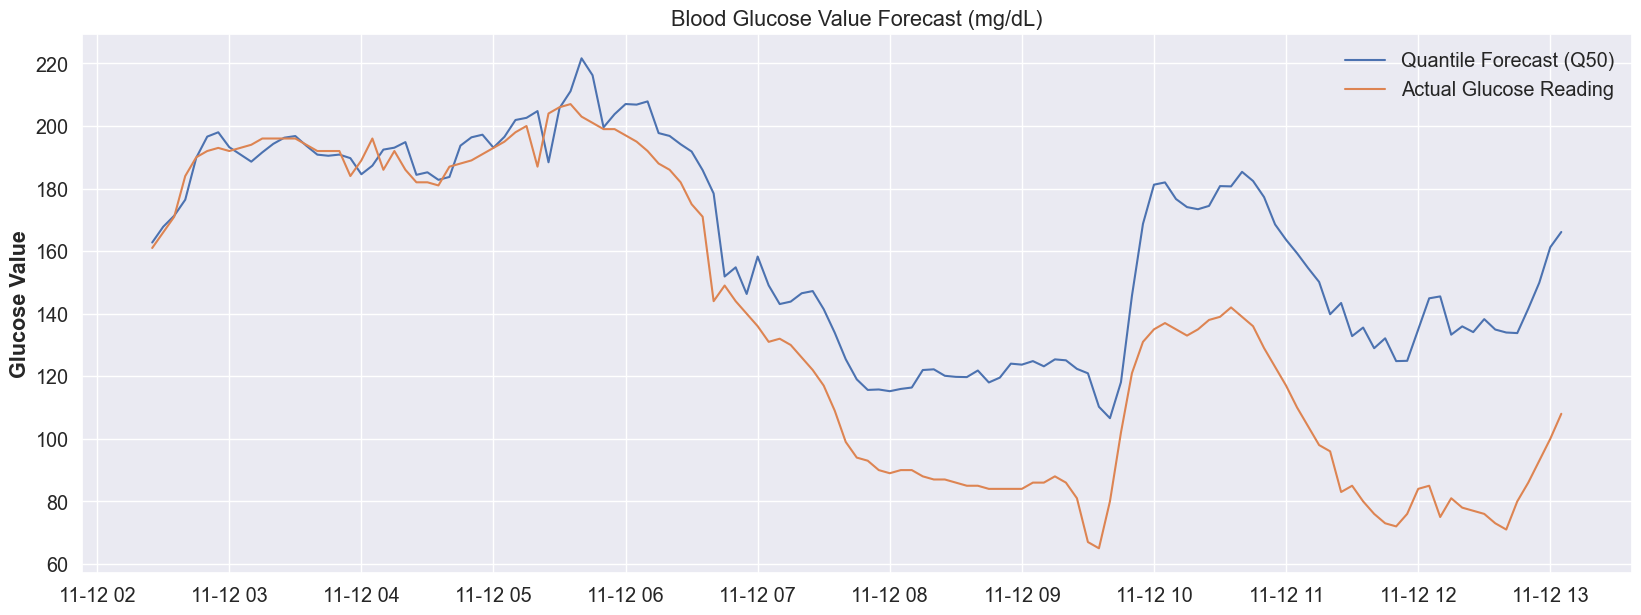

In [25]:
plot_forecast(dfY_validation, 'Q50')

Let's take a look at that same, time period at both Quantile 80 and 90.

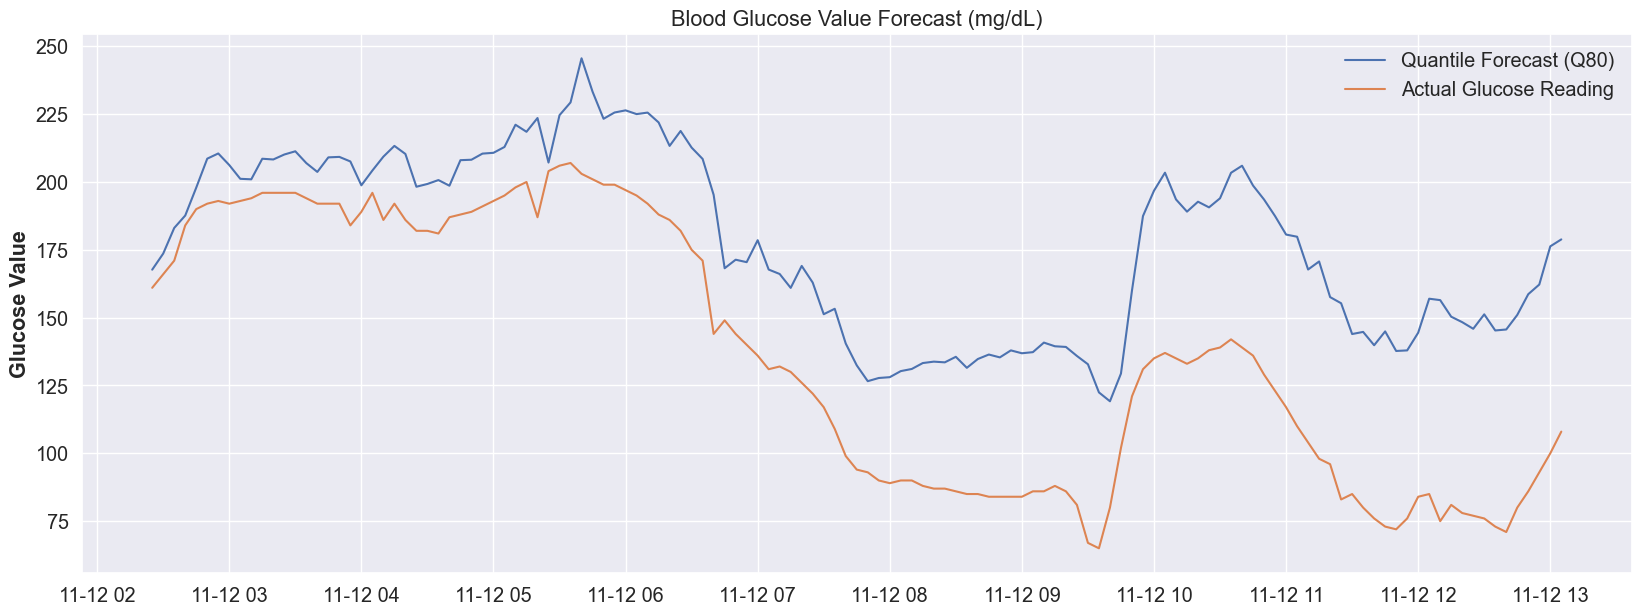

In [28]:
plot_forecast(dfY_validation, 'Q80')

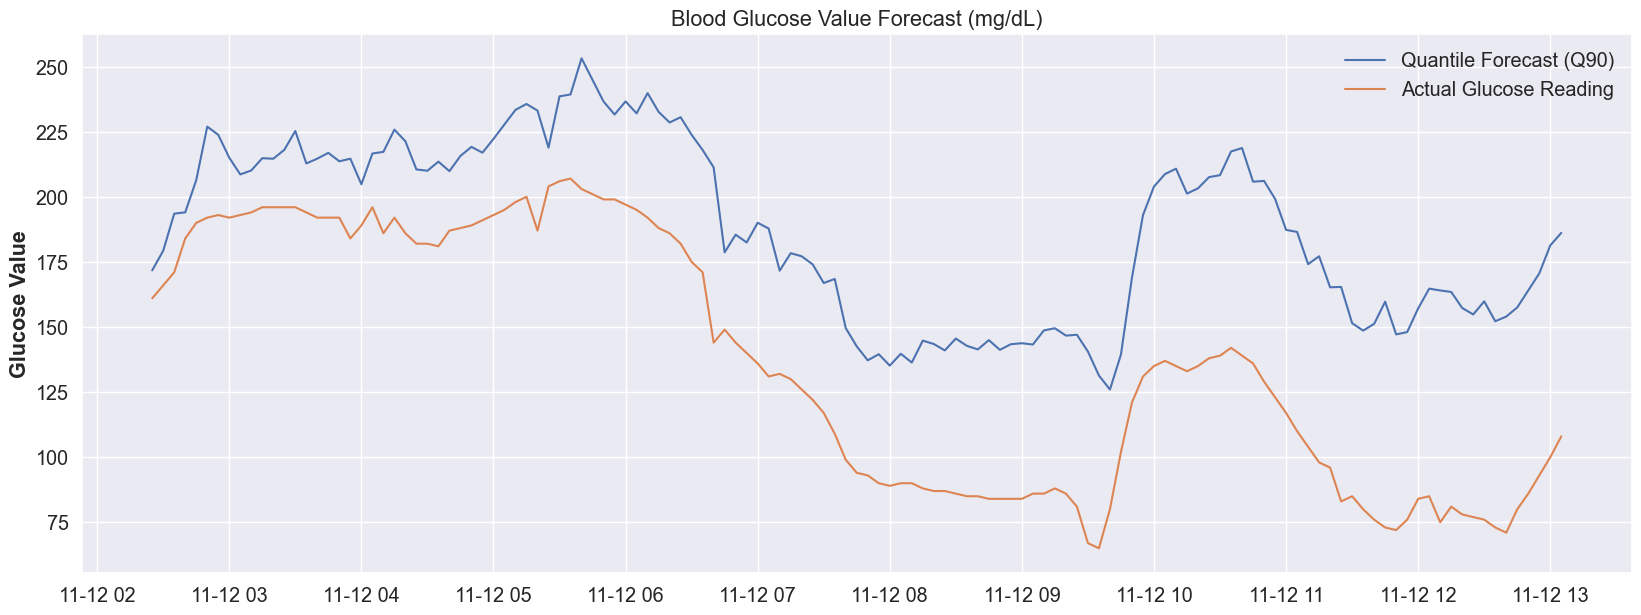

In [19]:
plot_forecast(dfY_validation, 'Q90')

In [20]:
# Run model against hold-out data

# Calculate the starting index for slicing based on the model's input chunk length
start_index_for_prediction = len(ts_ttest)  - model.input_chunk_length

# Use integer indices for slicing
input_series_for_prediction = ts_ttest[start_index_for_prediction:]

# Generate predictions
predictions = model.predict(
    n=len(ts_hold_out),
    series=input_series_for_prediction,
    past_covariates=cov_t,
    num_samples=N_SAMPLES,
    n_jobs=N_JOBS,
    verbose=False
)

In [21]:
# Initialize variables
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
dfY_hold_out = pd.DataFrame()
dfY_hold_out["Actual"] = TimeSeries.pd_series(ts_hold_out)  # Assuming ts_test is defined

# Initialize a list to store results
quantile_results = []

# Call the helper function predQ for every quantile
_ = [predQ(predictions, q, ts_hold_out, dfY_hold_out, quantile_results) for q in QUANTILES] 

# Print the quantile results in tabular format
print(tabulate(quantile_results, headers="keys", tablefmt="psql", showindex=False))

# Move the Q50 column to the left of the Actual column
col = dfY_hold_out.pop("Q50")
dfY_hold_out.insert(1, col.name, col)

# Display a part of the DataFrame
print(tabulate(dfY_hold_out.iloc[np.r_[0:2, -2:0]], headers='keys', tablefmt='psql', showindex=True))


+------------+--------+
|   Quantile |   RMSE |
|------------+--------|
|       0.01 |  16.96 |
|       0.1  |  18.54 |
|       0.2  |  24.39 |
|       0.5  |  36.87 |
|       0.8  |  49.24 |
|       0.9  |  56.19 |
|       0.99 |  73.51 |
+------------+--------+
+---------------------+----------+---------+----------+---------+---------+---------+---------+---------+
| datetime_col        |   Actual |     Q50 |      Q01 |     Q10 |     Q20 |     Q80 |     Q90 |     Q99 |
|---------------------+----------+---------+----------+---------+---------+---------+---------+---------|
| 2023-11-12 13:10:00 |      117 | 115.122 |  90.57   | 106.93  | 108.523 | 118.967 | 120.385 | 148.042 |
| 2023-11-12 13:15:00 |      127 | 122.461 |  98.8797 | 108.489 | 114.79  | 127.461 | 131.714 | 164.74  |
| 2023-11-12 23:50:00 |      261 | 290.691 | 229.546  | 250.726 | 262.99  | 304.907 | 310.931 | 320.73  |
| 2023-11-12 23:55:00 |      258 | 300.964 | 230.726  | 258.357 | 273.759 | 310.736 | 314.898 | 322.

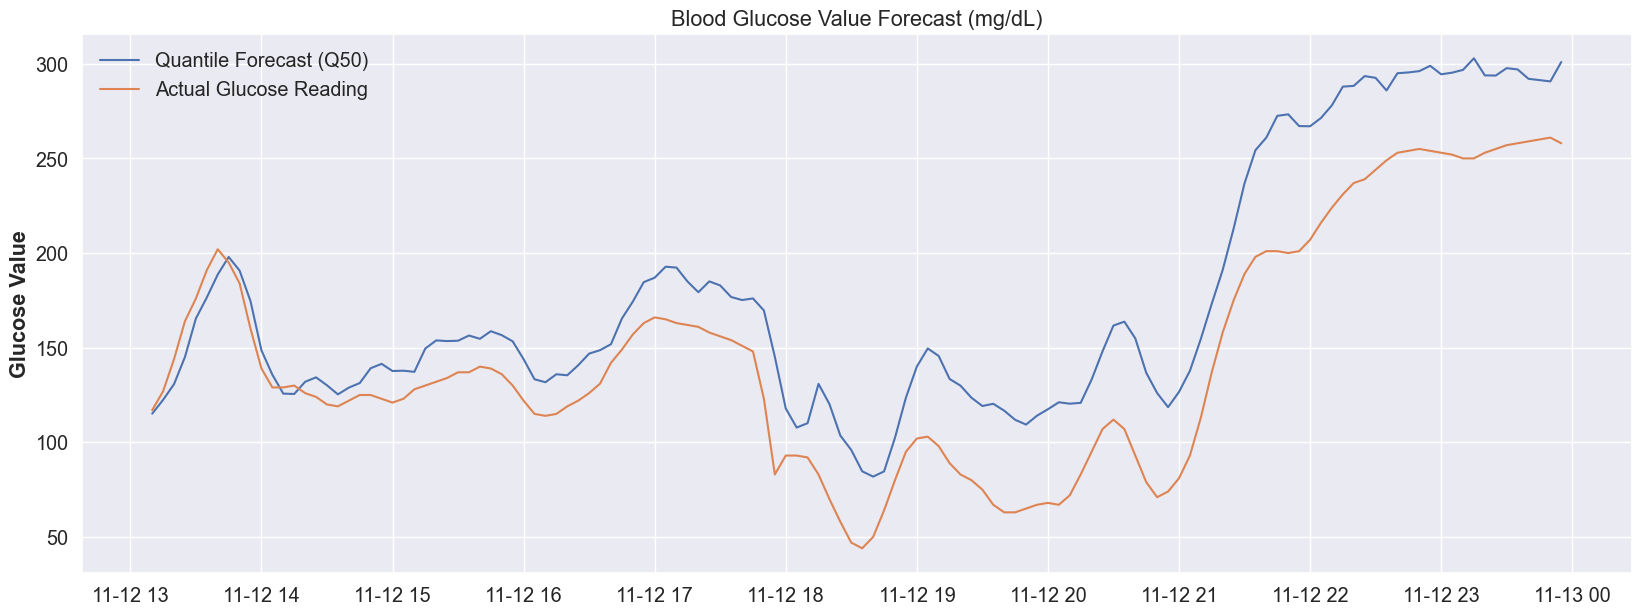

In [22]:
plot_forecast(dfY_hold_out, 'Q50')

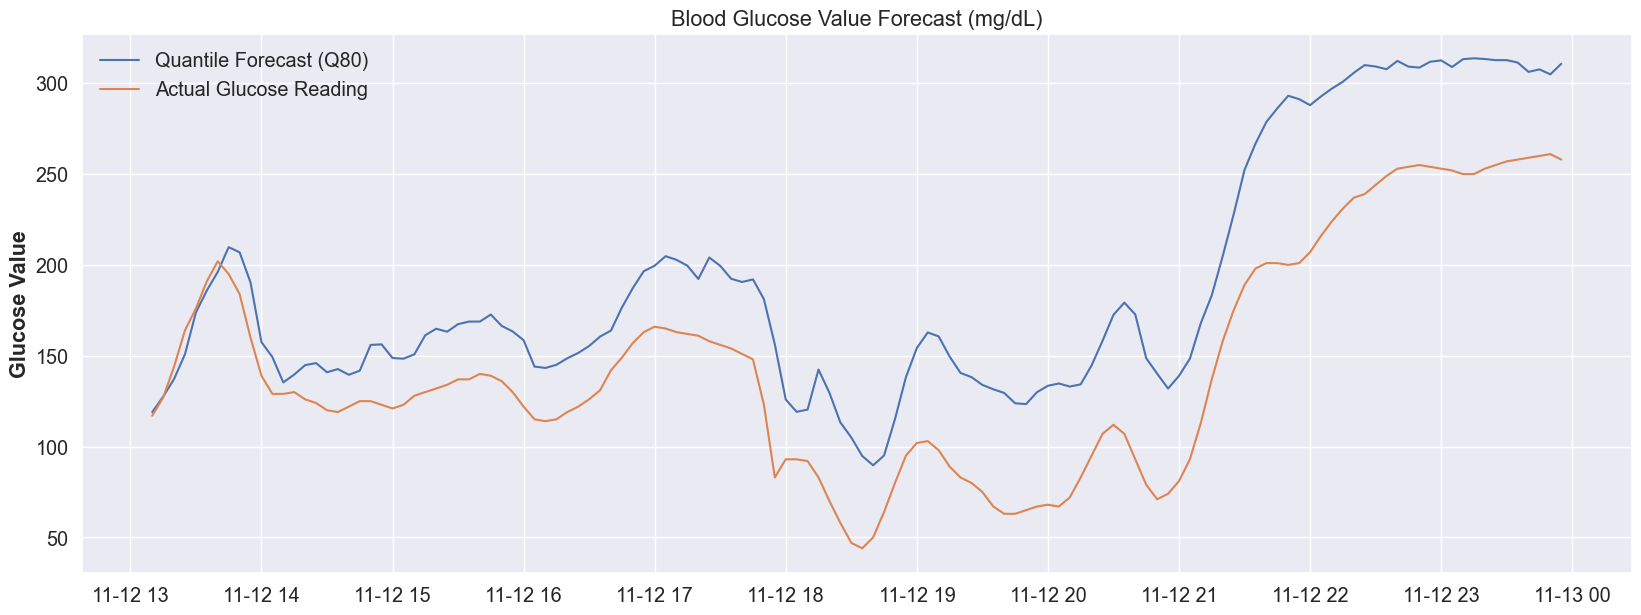

In [23]:
plot_forecast(dfY_hold_out, 'Q80')